In [81]:
# 파이참에서 쥬피터 노트북을 쓸때 pylot에서 무한 루프 방지
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

In [82]:
newsdata = fetch_20newsgroups(subset='train')

In [83]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [84]:
print(newsdata.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [85]:
print(newsdata['target'])

[7 4 4 ... 3 1 8]


In [86]:
newsdata['data'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [87]:
data = pd.DataFrame(newsdata['data'], columns=['email'])

In [88]:
data['email'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [89]:
data['target'] = newsdata['target']

In [90]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB
None


In [91]:
print(data.isnull().values.any())

False


In [92]:
print(data['email'].nunique())
print(data['target'].nunique())

11314
20


<Axes: xlabel='target'>

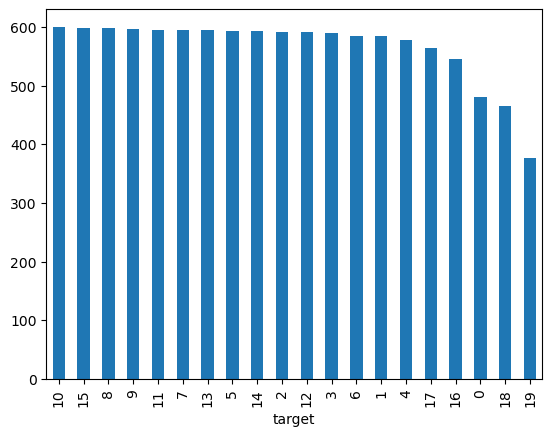

In [93]:
data['target'].value_counts().plot(kind='bar')

In [94]:
print(data.groupby('target').size().reset_index(name='count'))
# print(data.groupby('target').size())

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [95]:
# 왜 시리즈로 다시 불러오지...
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target

In [96]:
vocab_size = 10000
num_class = 20

In [97]:
# 전처리를 함수로 구현
def prepare_data(train_data, test_data, mode): # 모드는 binary, count, tfidf, freq 4가지 있음
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train_data) # 단어집합을 만드는 것이기 때문에 하나만 해도 된다. train_data만 해도 된다.
    x_train = tokenizer.texts_to_matrix(train_data, mode=mode)
    x_test = tokenizer.texts_to_matrix(test_data, mode=mode)
    return x_train, x_test, tokenizer.word_index

In [98]:
x_train, x_test, index_to_word = prepare_data(train_email, test_email, 'binary')
y_train = to_categorical(train_label,num_classes=num_class)
y_test = to_categorical(test_label, num_classes=num_class)

In [99]:
print('훈련 샘플 본문의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [100]:
def fit_and_evaluate(x_train, y_train, x_test, y_test):
    model = Sequential(
        [
            Dense(256, input_shape=(vocab_size,), activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_class, activation='softmax')
        ]
    )

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, batch_size=128, verbose=0, validation_split=0.1)
    score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)
    return score[1]

In [102]:
modes = ['binary', 'count','tfidf','freq']
for mode in modes:
    x_train, x_test, _ = prepare_data(train_email, test_email, mode)
    score = fit_and_evaluate(x_train, y_train, x_test, y_test)
    print("{} = {}".format(mode, score))

Epoch 1/5
80/80 [==============================] - 2s 23ms/step - loss: 2.2840 - accuracy: 0.3352 - val_loss: 0.9534 - val_accuracy: 0.8163
Epoch 2/5
80/80 [==============================] - 2s 21ms/step - loss: 0.8717 - accuracy: 0.7547 - val_loss: 0.4691 - val_accuracy: 0.8799
Epoch 3/5
80/80 [==============================] - 2s 20ms/step - loss: 0.4352 - accuracy: 0.8853 - val_loss: 0.3640 - val_accuracy: 0.8966
Epoch 4/5
80/80 [==============================] - 2s 22ms/step - loss: 0.2649 - accuracy: 0.9318 - val_loss: 0.3226 - val_accuracy: 0.9055
Epoch 5/5
80/80 [==============================] - 2s 21ms/step - loss: 0.1781 - accuracy: 0.9558 - val_loss: 0.3115 - val_accuracy: 0.9072
binary = 0.82753586769104
Epoch 1/5
80/80 [==============================] - 2s 23ms/step - loss: 2.7917 - accuracy: 0.2387 - val_loss: 1.7109 - val_accuracy: 0.7385
Epoch 2/5
80/80 [==============================] - 2s 21ms/step - loss: 1.4620 - accuracy: 0.6244 - val_loss: 0.7035 - val_accuracy: 0